In [1]:
import pysam
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import re

### BAM clipped reads at coverage transitions

- Extract some reads by name and check the clipped sequence

In [2]:
def print_color(text, substrings):
    # Define the ANSI escape codes for red text
    RED = '\033[91m'
    RESET = '\033[0m'
    
    # Join substrings into a regex pattern
    pattern = "|".join(re.escape(sub) for sub in substrings)
    
    # Find all matches
    matches = re.finditer(pattern, text)
    last_end = 0
    
    result = []
    for match in matches:
        # Append the non-matching part
        result.append(text[last_end:match.start()])
        
        # Append the matching part with red color
        result.append(f"{RED}({match.group()}){RESET}")
        
        # Update the last end position
        last_end = match.end()
    
    # Append any remaining part of the text
    result.append(text[last_end:])
    
    # Print the result as a single joined string
    print("".join(result))

In [6]:
def extract_clipped_sequences(bam_path, read_names, chrom, start, end, motifs_to_search):
    # Open the BAM file
    bam_file = pysam.AlignmentFile(bam_path, "rb")

    # Initialize an empty list to store clipped sequences
    per_read_clipped_sequences = {}

    # Iterate through the BAM file to find the read
    for read in bam_file.fetch(chrom, start, end):
        read_name = read.query_name
        if read_name not in read_names:
            continue

        if read_name not in per_read_clipped_sequences:
            per_read_clipped_sequences[read_name] = []

        print(f"Found read: {read_name}")
        # Check for soft or hard clipping (S or H in CIGAR)
        cigar_tuples = read.cigartuples

        if cigar_tuples:
            # Extract the clipped part of the sequence
            seq = read.query_sequence

            # Check for soft or hard clipping at the start
            if cigar_tuples[0][0] in {4, 5}:
                clipped_length = cigar_tuples[0][1]
                per_read_clipped_sequences[read_name].append( seq[:clipped_length] )
                print("Clipped start:")
                print_color(seq[:clipped_length], motifs_to_search)

            # Check for soft or hard clipping at the end
            if cigar_tuples[-1][0] in {4, 5}:
                clipped_length = cigar_tuples[-1][1]
                per_read_clipped_sequences[read_name].append( seq[-clipped_length:] )
                print("Clipped end:")
                print_color(seq[-clipped_length:], motifs_to_search)
                

    # Close the BAM file
    bam_file.close()

    return per_read_clipped_sequences

In [7]:
import mappy as mp

def retrieve_seq(reference_fasta, query_sequence):
    # Load the reference FASTA file
    aligner = mp.Aligner(reference_fasta)
    if not aligner:
        print(f"ERROR: failed to load reference file {reference_fasta}")
        return

    # Search for the query sequence
    print(f"Searching for sequence: {query_sequence} in {reference_fasta}")
    for hit in aligner.map(query_sequence):
        print(f"Query: {query_sequence}")
        print(f"Reference: {hit.ctg}, Start: {hit.r_st}, End: {hit.r_en}")
        print(f"Mapping quality: {hit.mapq}")
        print(f"Cigar: {hit.cigar_str}, Score: {hit.mlen}/{hit.blen} = {hit.mlen/hit.blen:.2%}% idy")
        print(f"Strand: {'+' if not hit.strand else '-'}")
        print("---")

In [8]:
#from pysam import VariantFile
orig_nucl = "ACGT"
comp_nucl = "TGCA"
complement = str.maketrans(orig_nucl, comp_nucl)
reverse_complement = lambda s: s.upper().translate(complement)[::-1]

def get_all_motif_kmers(motif):
    all_motifs_kmers = []
    for i in range(len(motif)):
        k = len(motif)
        rotation = motif[i:] + motif[:i] # GTGGG + T motif[:i]
        
        all_motifs_kmers.append(rotation)
        all_motifs_kmers.append(reverse_complement(rotation))
        
    return set(all_motifs_kmers)

telomeric_motif = "TGTGGG"

all_telo = get_all_motif_kmers(telomeric_motif)

In [9]:
def overlap(s1, s2, min_length=10):
    """Finds the longest overlap between the suffix of s1 and the prefix of s2."""
    start = 0  # Start searching from the beginning of s1
    while True:
        start = s1.find(s2[:min_length], start)  # Find the start of a potential overlap
        if start == -1:
            return 0  # No overlap found
        # Check if the suffix of s1 matches the prefix of s2
        if s2.startswith(s1[start:]):
            return len(s1) - start
        start += 1

def assemble_sequences(sequences):
    """Assembles a list of sequences into a single contiguous DNA string."""
    while len(sequences) > 1:
        max_overlap = 0
        best_pair = (0, 1)  # Default best pair of indices

        # Find the pair with the maximum overlap
        for i in range(len(sequences)):
            for j in range(len(sequences)):
                if i != j:
                    ov = overlap(sequences[i], sequences[j])
                    if ov > max_overlap:
                        max_overlap = ov
                        best_pair = (i, j)

        # Merge the best pair
        seq1, seq2 = best_pair
        if max_overlap == 0:
            # No overlaps found, concatenate any two sequences
            sequences[seq1] += sequences.pop(seq2)
        else:
            # Merge the sequences with the maximum overlap
            sequences[seq1] = sequences[seq1] + sequences[seq2][max_overlap:]
            sequences.pop(seq2)

    return sequences[0]

### H2C3 Chrom 6 2,641,598 - 2,642,100

In [37]:
read_names = [
    "A00311:73:HHTG2DRXX:1:2215:31331:20024",
    "A00311:73:HHTG2DRXX:1:2102:14570:10911",
    "A00311:73:HHTG2DRXX:2:2223:16034:6809",
    "A00311:73:HHTG2DRXX:1:2129:24731:6183",
    "A00311:73:HHTG2DRXX:1:2158:31132:13291",
]

# Example usage
chrom = "Chrom_6"
start = 2641598
end = 2642100
bam_path = "/media/urbe/MyBDrive1/Antoine/27-10-21_VariantCalling_MA/H2C3/H2C3.sorted.CALL.bam"
clipped_seqs = extract_clipped_sequences(bam_path, read_names, chrom, start, end, all_telo)

print("Extracted clipped sequences:")
for read, seqs in clipped_seqs.items():
    print(read, seqs)

Found read: A00311:73:HHTG2DRXX:2:2223:16034:6809
Found read: A00311:73:HHTG2DRXX:1:2129:24731:6183
Clipped end:
CTATACGAAAAAGNAAGCAGTTGGTTATTTCCTGTTCGGAAGAAATAACCGATTTATCAAAGAATAAAATGTGTGAGATAGAAAAGAAAATA
Found read: A00311:73:HHTG2DRXX:1:2215:31331:20024
Clipped end:
CTATACGAAAAAGAAAGCAGTTGGTTATTTCCTGTTCGAAAGAAATAACCGATTTATCAAAGAATAAAATGTTTGAGATAGAAAAGAAAATAAAAGAGTTGTTTTGTTTTATGTAGTTTA
Found read: A00311:73:HHTG2DRXX:2:2223:16034:6809
Clipped end:
CTATACGAAAAAGAAAGCAGTTGGTTATTTCCTGTTCGAAAGAAATAACCGATTTATCAAAGAATAAAATGTTTGAGATAGAAAAGAAAAAAAAAGAGTTGTTTTGTTTTATGTAGTTTA
Found read: A00311:73:HHTG2DRXX:1:2158:31132:13291
Clipped end:
CTATACGAAAAAGAAAGCAGTTGGTTATTTCCTGTTCGAAAGAAATAACCGATTTATCAAAGAATAAAATGTTTG
Found read: A00311:73:HHTG2DRXX:1:2158:31132:13291
Clipped end:
CTATACGAAAAAGAAAGCAGTTGGTTATTTCCTGTTCGAAAGAAATAACCGATTTATCAAAGAATAAAATGTTTG
Found read: A00311:73:HHTG2DRXX:1:2102:14570:10911
Clipped end:
CTATACGAAACANCCAGCAGTTGGTTATTTCCTGTTCGAAAGAACTAACCGATTTATCAAAGAATAAAATGTTTGAGAGCG

**No telomeric motifs found in clips**

#### Do clips align somewhere else in the genome?

In [31]:
reference = "../19-11-21_VariantCalling_ARC/input/reference.fa"
sequence_to_search = "CTATACGAAACANCCAGCAGTTGGTTATTTCCTGTTCGAAAGAACTAACCGATTTATCAAAGAATAAAATGTTTGAGAGCGACAAGAAATAAAAAGAGGTGGATTTTTTTATGNAGTTTGTTGACTCGTTGNTGTCCAGATAGTTCTTGGCGTCAGCGGAACTTCTATCACAAAAGACGC"
retrieve_seq(reference, sequence_to_search)

Searching for sequence: CTATACGAAACANCCAGCAGTTGGTTATTTCCTGTTCGAAAGAACTAACCGATTTATCAAAGAATAAAATGTTTGAGAGCGACAAGAAATAAAAAGAGGTGGATTTTTTTATGNAGTTTGTTGACTCGTTGNTGTCCAGATAGTTCTTGGCGTCAGCGGAACTTCTATCACAAAAGACGC in ../19-11-21_VariantCalling_ARC/input/reference.fa
Query: CTATACGAAACANCCAGCAGTTGGTTATTTCCTGTTCGAAAGAACTAACCGATTTATCAAAGAATAAAATGTTTGAGAGCGACAAGAAATAAAAAGAGGTGGATTTTTTTATGNAGTTTGTTGACTCGTTGNTGTCCAGATAGTTCTTGGCGTCAGCGGAACTTCTATCACAAAAGACGC
Reference: Chrom_5, Start: 217365, End: 217539
Mapping quality: 0
Cigar: 168M1I6M, Score: 146/172 = 84.88%% idy
Strand: -
---
Query: CTATACGAAACANCCAGCAGTTGGTTATTTCCTGTTCGAAAGAACTAACCGATTTATCAAAGAATAAAATGTTTGAGAGCGACAAGAAATAAAAAGAGGTGGATTTTTTTATGNAGTTTGTTGACTCGTTGNTGTCCAGATAGTTCTTGGCGTCAGCGGAACTTCTATCACAAAAGACGC
Reference: Chrom_5, Start: 226056, End: 226230
Mapping quality: 0
Cigar: 6M1I168M, Score: 146/172 = 84.88%% idy
Strand: -
---
Query: CTATACGAAACANCCAGCAGTTGGTTATTTCCTGTTCGAAAGAACTAACCGATTTATCAAAGAATAAAATGTTTGAGAGCGACAAGAAATAAAAAGAGGTGGATTTT

#### Blasting the sequence:

`Clipped sequence at H2C3: CTATACGAAACANCCAGCAGTTGGTTATTTCCTGTTCGAAAGAACTAACCGATTTATCAAAGAATAAAATGTTTGAGAGCGACAAGAAATAAAAAGAGGTGGATTTTTTTATGNAGTTTGTTGACTCGTTGNTGTCCAGATAGTTCTTGGCGTCAGCGGAACTTCTATCACAAAAGACGC`

Returns:
- Sequence ID: EU643487.1Length: 39321Number of Matches: 2
```raw
RID: 1TY0CSGV016
Job Title:Nucleotide Sequence
Program: BLASTN
Query: None ID: lcl|Query_4042407(dna) Length: 180
Database: core_nt Core nucleotide BLAST database
Sequences producing significant alignments:
                                                                  Scientific      Common                     Max    Total Query   E   Per.   Acc.
Description                                                       Name            Name            Taxid      Score  Score cover Value Ident  Len        Accession
Adineta vaga clone 136D10 retrotransposons Athena-AvMs and...     Adineta vaga    NA              104782     167    330   97%   5e-37 83.43  39321      EU643487.1
Adineta vaga clone 119E19 retrotransposons Athena-AvM and...      Adineta vaga    NA              104782     167    325   97%   5e-37 83.43  22260      EU643486.1
Adineta vaga telomere M1 clone 184A11 telomeric repeat and...     Adineta vaga    NA              104782     167    330   97%   5e-37 83.43  10926      EF485018.1


1. Adineta vaga clone 136D10 retrotransposons Athena-AvMs and Athena-AvO, complete sequence; cytochrome P450 monooxygenase-like protein, hypothetical protein, putative methylase-like protein, and caldecrin precursor isoform 1-like protein genes, complete cds; transposons hobo-like, piggyBac-like, helitron-like, and piggyBac-like, complete sequence; and unknown gene
2. Adineta vaga clone 119E19 retrotransposons Athena-AvM and Athena, complete sequence; putative disease resistance protein-like protein and muscarinic receptor 2-like protein genes, complete cds; and unknown gene
3. Adineta vaga telomere M1 clone 184A11 telomeric repeat and subterminal DNA junction
```


### H2C3 Chrom_6:4,039,511-4,040,597

In [38]:
read_names = [
    "A00311:73:HHTG2DRXX:1:2144:23647:27164",
    "A00311:73:HHTG2DRXX:1:2172:22706:5556",
    "A00311:73:HHTG2DRXX:1:2252:24722:28494",
    "A00311:73:HHTG2DRXX:1:2274:18810:14465",
    "A00311:73:HHTG2DRXX:2:2134:24270:22075",
    "A00311:73:HHTG2DRXX:2:2178:1108:32534",
    "A00311:73:HHTG2DRXX:2:2210:24632:15060",
]

# Example usage
chrom = "Chrom_6"
start = 4039511
end = 4040597
bam_path = "/media/urbe/MyBDrive1/Antoine/27-10-21_VariantCalling_MA/H2C3/H2C3.sorted.CALL.bam"
clipped_seqs = extract_clipped_sequences(bam_path, read_names, chrom, start, end, all_telo)

print("Extracted clipped sequences:")
for read, seqs in clipped_seqs.items():
    print(read, seqs)

Found read: A00311:73:HHTG2DRXX:2:2134:24270:22075
Clipped end:
TGAAATCTTAATTAAATGGCATTTTATTAAACAAGTTTTTAAAACAACCAATACTAAAGGCAAGGTAAATTTAAACCTTATATAAAAAAAAAACAAAGAAAAAAAATAAAAAAAAACGAAACAACAAAATTTAAATAAAAAAAATACAATAATTACTTGTTTGAAAAAAAAAATAATAACGCAAAATTACTTTTTATTCAACATCATAAACA
Found read: A00311:73:HHTG2DRXX:2:2210:24632:15060
Clipped start:
AACTCTTTTTTTTTTCTTTTCTATCTCAAACATTTTATTCTTTGATAAATCGGTTATTTCTTTCGAACAGGAAATAACCAACTGCTTTCTTTTTCGTATAGTT
Found read: A00311:73:HHTG2DRXX:1:2252:24722:28494
Clipped start:
AACTCTTTTTTTTTTCTTTTCTATCTCAAACATTTTATTCTTTGATAAATCGGTTATTTCTTTCGAACAGGAAATAACCAACTGCTTTCTTTTTCGTATAGTT
Found read: A00311:73:HHTG2DRXX:2:2178:1108:32534
Clipped start:
TCTTTTTTTTTTCTTTTCTATCTCAAACATTTTATTCTTTGATAAATCGGTTATTTCTTTCGAACAGGAAATAACCAACTGCTTTCTTTTTCGTATAGTT
Found read: A00311:73:HHTG2DRXX:1:2172:22706:5556
Clipped start:
GGTTATTTCTTTCGAACAGGAAATAACCAACTGCTTTCTTTTTCGTATAGTT
Found read: A00311:73:HHTG2DRXX:1:2274:18810:14465
Clipped start:
AATAAACTACATAAAACAAAACAACTCTTTTTT

**No telomeric motifs found in clips**

**Micro assembly of clipped sequences**

In [40]:
retrieved_clipped_seqs = [
    'TGAAATCTTAATTAAATGGCATTTTATTAAACAAGTTTTTAAAACAACCAATACTAAAGGCAAGGTAAATTTAAACCTTATATAAAAAAAAAACAAAGAAAAAAAATAAAAAAAAACGAAACAACAAAATTTAAATAAAAAAAATACAATAATTACTTGTTTGAAAAAAAAAATAATAACGCAAAATTACTTTTTATTCAACATCATAAACA',
    'AACTCTTTTTTTTTTCTTTTCTATCTCAAACATTTTATTCTTTGATAAATCGGTTATTTCTTTCGAACAGGAAATAACCAACTGCTTTCTTTTTCGTATAGTT',
    'TTTTCTATCTCAAACATTTTATTCTTTGATAAATCGGTTATTTCTTTCGAACAGGAAATAACCAACTGCTTTCTTTTTCGTATAGTT',
    'AACTCTTTTTTTTTTCTTTTCTATCTCAAACATTTTATTCTTTGATAAATCGGTTATTTCTTTCGAACAGGAAATAACCAACTGCTTTCTTTTTCGTATAGTT',
    'TCTTTTTTTTTTCTTTTCTATCTCAAACATTTTATTCTTTGATAAATCGGTTATTTCTTTCGAACAGGAAATAACCAACTGCTTTCTTTTTCGTATAGTT',
    'TCTTTTTTTTTTCTTTTCTATCTCAAACATTTTATTCTTTGATAAATCGGTTATTTCTTTCGAACAGGAAATAACCAACTGCTTTCTTTTTCGTATAGTT',
    'GGTTATTTCTTTCGAACAGGAAATAACCAACTGCTTTCTTTTTCGTATAGTT',
    'AATAAACTACATAAAACAAAACAACTCTTTTTTTTTTCTTTTCTATCTCAAACATTTTATTCTTTGATAAATCGGTTATTTCTTTCGAACAGGAAATAACCAACTGCTTTCTTTTTCGTATAGTT',
    'ACAAAACAACTCTTTTTTTTTTCTTTTCTATCTCAAACATTTTATTCTTTGATAAATCGGTTATTTCTTTCGAACAGGAAATAACCAACTGCTTTCTTTTTCGTATAGTT',
]
asm = assemble_sequences(retrieved_clipped_seqs)
asm

'TGAAATCTTAATTAAATGGCATTTTATTAAACAAGTTTTTAAAACAACCAATACTAAAGGCAAGGTAAATTTAAACCTTATATAAAAAAAAAACAAAGAAAAAAAATAAAAAAAAACGAAACAACAAAATTTAAATAAAAAAAATACAATAATTACTTGTTTGAAAAAAAAAATAATAACGCAAAATTACTTTTTATTCAACATCATAAACAAATAAACTACATAAAACAAAACAACTCTTTTTTTTTTCTTTTCTATCTCAAACATTTTATTCTTTGATAAATCGGTTATTTCTTTCGAACAGGAAATAACCAACTGCTTTCTTTTTCGTATAGTT'

#### Do clips align somewhere else in the genome?

In [42]:
reference = "../19-11-21_VariantCalling_ARC/input/reference.fa"
sequence_to_search = "TGAAATCTTAATTAAATGGCATTTTATTAAACAAGTTTTTAAAACAACCAATACTAAAGGCAAGGTAAATTTAAACCTTATATAAAAAAAAAACAAAGAAAAAAAATAAAAAAAAACGAAACAACAAAATTTAAATAAAAAAAATACAATAATTACTTGTTTGAAAAAAAAAATAATAACGCAAAATTACTTTTTATTCAACATCATAAACAAATAAACTACATAAAACAAAACAACTCTTTTTTTTTTCTTTTCTATCTCAAACATTTTATTCTTTGATAAATCGGTTATTTCTTTCGAACAGGAAATAACCAACTGCTTTCTTTTTCGTATAGTT"
retrieve_seq(reference, sequence_to_search)

Searching for sequence: TGAAATCTTAATTAAATGGCATTTTATTAAACAAGTTTTTAAAACAACCAATACTAAAGGCAAGGTAAATTTAAACCTTATATAAAAAAAAAACAAAGAAAAAAAATAAAAAAAAACGAAACAACAAAATTTAAATAAAAAAAATACAATAATTACTTGTTTGAAAAAAAAAATAATAACGCAAAATTACTTTTTATTCAACATCATAAACAAATAAACTACATAAAACAAAACAACTCTTTTTTTTTTCTTTTCTATCTCAAACATTTTATTCTTTGATAAATCGGTTATTTCTTTCGAACAGGAAATAACCAACTGCTTTCTTTTTCGTATAGTT in ../19-11-21_VariantCalling_ARC/input/reference.fa
Query: TGAAATCTTAATTAAATGGCATTTTATTAAACAAGTTTTTAAAACAACCAATACTAAAGGCAAGGTAAATTTAAACCTTATATAAAAAAAAAACAAAGAAAAAAAATAAAAAAAAACGAAACAACAAAATTTAAATAAAAAAAATACAATAATTACTTGTTTGAAAAAAAAAATAATAACGCAAAATTACTTTTTATTCAACATCATAAACAAATAAACTACATAAAACAAAACAACTCTTTTTTTTTTCTTTTCTATCTCAAACATTTTATTCTTTGATAAATCGGTTATTTCTTTCGAACAGGAAATAACCAACTGCTTTCTTTTTCGTATAGTT
Reference: Chrom_5, Start: 221645, End: 221769
Mapping quality: 0
Cigar: 88M1I36M, Score: 124/125 = 99.20%% idy
Strand: -
---
Query: TGAAATCTTAATTAAATGGCATTTTATTAAACAAGTTTTTAAAACAACCAATACTAAAGGCAAGGTAAATTTAAACCTTATATAAAAAAAAAACAAAGAAAAAAAAT

#### Blasting the sequence:

`Clipped sequence at H2C3: TGAAATCTTAATTAAATGGCATTTTATTAAACAAGTTTTTAAAACAACCAATACTAAAGGCAAGGTAAATTTAAACCTTATATAAAAAAAAAACAAAGAAAAAAAATAAAAAAAAACGAAACAACAAAATTTAAATAAAAAAAATACAATAATTACTTGTTTGAAAAAAAAAATAATAACGCAAAATTACTTTTTATTCAACATCATAAACAAATAAACTACATAAAACAAAACAACTCTTTTTTTTTTCTTTTCTATCTCAAACATTTTATTCTTTGATAAATCGGTTATTTCTTTCGAACAGGAAATAACCAACTGCTTTCTTTTTCGTATAGTT`

Returns:
- Sequence ID: EU643487.1Length: 39321Number of Matches: 2
```raw
RID: 1TZDHC72016	
Job Title:Nucleotide Sequence 				
Program: BLASTN 
Database: core_nt Core nucleotide BLAST database
Query #1:  Query ID: lcl|Query_7364167 Length: 337

Sequences producing significant alignments:
                                                                  Scientific      Common                     Max    Total Query   E   Per.   Acc.
Description                                                       Name            Name            Taxid      Score  Score cover Value Ident  Len        Accession
Adineta vaga clone 136D10 retrotransposons Athena-AvMs and...     Adineta vaga    NA              104782     231    456   37%   4e-56 100.00 39321      EU643487.1
Adineta vaga telomere M1 clone 184A11 telomeric repeat and...     Adineta vaga    NA              104782     231    456   37%   4e-56 100.00 10926      EF485018.1
Adineta vaga clone 119E19 retrotransposons Athena-AvM and...      Adineta vaga    NA              104782     224    449   37%   7e-54 99.20  22260      EU643486.1

>Adineta vaga clone 136D10 retrotransposons Athena-AvMs and Athena-AvO, complete sequence; cytochrome P450 monooxygenase-like protein, hypothetical protein, putative methylase-like protein, and caldecrin precursor isoform 1-like protein genes, complete cds; transposons hobo-like, piggyBac-like, helitron-like, and piggyBac-like, complete sequence; and unknown gene
Sequence ID: EU643487.1 Length: 39321

>Adineta vaga telomere M1 clone 184A11 telomeric repeat and subterminal DNA junction
Sequence ID: EF485018.1 Length: 10926

>Adineta vaga clone 119E19 retrotransposons Athena-AvM and Athena, complete sequence; putative disease resistance protein-like protein and muscarinic receptor 2-like protein genes, complete cds; and unknown gene
Sequence ID: EU643486.1 Length: 22260
```


### H4A4 Chrom_6:8077000-807800

Conclusion: Soft and hard clips on the right side are actually mapping to CHROMOSOME 4

- The right side of this deletion contains reads that are end-joined to C4 **in the region with a duplication**

In [49]:
read_names = [
    "A00305:224:HT5M2DRXX:2:2230:17761:4038",
    "A00305:224:HT5M2DRXX:1:2209:7943:5008",
    "A00305:214:HNVCGDRXX:1:2205:14986:2300",
    "A00305:224:HT5M2DRXX:2:2247:8910:3865",
    "A00305:224:HT5M2DRXX:2:2127:7889:18411",
    "A00305:224:HT5M2DRXX:1:2216:29577:2456",
    "A00305:224:HT5M2DRXX:1:2229:10257:3380",
    "A00305:224:HT5M2DRXX:1:2133:12689:32706",
]

# Example usage
chrom = "Chrom_6"
start = 8077000
end = 8078000
bam_path = "/media/urbe/MyBDrive1/Antoine/27-10-21_VariantCalling_MA/H4A4/H4A4.sorted.CALL.bam"
clipped_seqs = extract_clipped_sequences(bam_path, read_names, chrom, start, end, all_telo)

print("Extracted clipped sequences:")
for read, seqs in clipped_seqs.items():
    print(read, seqs)

Found read: A00305:224:HT5M2DRXX:1:2216:29577:2456
Clipped end:
AAAAAAAACCTATAAAAATGATAATATATATTAATCATACTTTATAGAAAAGTGAAA
Found read: A00305:224:HT5M2DRXX:2:2230:17761:4038
Clipped start:
CAATGAGATCTCGGCTCGGCTCGATCGCCTCGATGATGAGTTCATTGATTTGGCGTTCTCTGCGATCACTCGAATCTTGGGTAATTCACTGTCCAGTCGAGCCGGCGTGGAAGCCGTGATTCGGCAGGT
Clipped end:
GCCACCCCCGTAACGGTCAGACTTTCGGCCCGTGAGTGGGAGCTGCTGGGAGAGCAGGGGCGCTCGGCCCTGACGACCGGAAGCGTTTCCCACTGGGTTG
Found read: A00305:224:HT5M2DRXX:2:2230:17761:4038
Clipped end:
GCCACCCCCGTAACGGTCAGACTTTCGGCCCGTGATTGGGAGCTGCTGGGAGAGCAGGGGCGCTCGGCCCTGACGACCGGAAGCGTTTCCCACTGGGTTGTCGACCCCAAGATTGAACTCGGGGGCTGCATCGTCGACGGCGGACGAGGCAGCCTCGACGGACGTCTGGAGACGCAGCTCGCGAAGATGAAGCAGGCGCTTCTGGATTGCCATGCGGGGCAACGTGAGC
Found read: A00305:224:HT5M2DRXX:1:2229:10257:3380
Found read: A00305:224:HT5M2DRXX:1:2209:7943:5008
Clipped start:
CGGAGTGGACTACTTGAAGTATGGTTTCAATATGCTAATACGGTCAATAATAGTTATATATAAGTCACTGATCGACGATCCTGCCATATTT
Found read: A00305:224:HT5M2DRXX:1:2229:10257:3380
Clipped start:


In [50]:
retrieved_clipped_seqs = [
    'TTATATAATAATTTTTATTTATATTAAACATTATTTATCGATTAGTTAAATAATATTTTTTTTTTGAT',
    'CGGAGTGGACTACTTGAAGTATGGTTTCAATATGCTAATACGGTCAATAATAGTTATATATAAGTCACTGATCGACGATCCTGCCATATTT',
    'AAAGTTTCACTCACTACTGAACATCTTTTGAATTATAATATGACCTAGAATTAGAAAAAAGACCTTTCACAAGCC',
    'CGGAGTGGACTACTTGAAGTATGGTTTCAATATGCTAATACGGTCAATAATAGTTATATATAAGTCACTGATCGACGATCCTGCCATATTT',
    'TTATATAATAATTTTTATTTATATTAAACATTATTTATCGATTAGTTAAATAATATTTTTTTTTTGAT',
    'AAAGTTTCACTCACTACTGAACATCTTTTGAATTATAATATGACCTAGAATTAGAAAAAAGACCTTTCACAAGCC',
    'AGAAATCATCGTAACCTTTAGAAACAAAAATATGATCCTTTCAATTAAAAAGTTTCACTCACTACTGAACATCTTTTGAATTATTATATGACCTAGAATTAGAAAAAAGACCTTTCACCAGCC',
    'CCTTTCAATTAAAAAGTTTCACTCAATACTGAACATCTTTTGAATTATTATATGACATAGAATTAGAAAAAAGACCTTTCACCAGCC',
]
asm = assemble_sequences(retrieved_clipped_seqs)
asm

'TTATATAATAATTTTTATTTATATTAAACATTATTTATCGATTAGTTAAATAATATTTTTTTTTTGATCGGAGTGGACTACTTGAAGTATGGTTTCAATATGCTAATACGGTCAATAATAGTTATATATAAGTCACTGATCGACGATCCTGCCATATTTAAAGTTTCACTCACTACTGAACATCTTTTGAATTATAATATGACCTAGAATTAGAAAAAAGACCTTTCACAAGCCAGAAATCATCGTAACCTTTAGAAACAAAAATATGATCCTTTCAATTAAAAAGTTTCACTCACTACTGAACATCTTTTGAATTATTATATGACCTAGAATTAGAAAAAAGACCTTTCACCAGCCCCTTTCAATTAAAAAGTTTCACTCAATACTGAACATCTTTTGAATTATTATATGACATAGAATTAGAAAAAAGACCTTTCACCAGCC'

In [51]:
reference = "../19-11-21_VariantCalling_ARC/input/reference.fa"
sequence_to_search = "TTATATAATAATTTTTATTTATATTAAACATTATTTATCGATTAGTTAAATAATATTTTTTTTTTGATCGGAGTGGACTACTTGAAGTATGGTTTCAATATGCTAATACGGTCAATAATAGTTATATATAAGTCACTGATCGACGATCCTGCCATATTTAAAGTTTCACTCACTACTGAACATCTTTTGAATTATAATATGACCTAGAATTAGAAAAAAGACCTTTCACAAGCCAGAAATCATCGTAACCTTTAGAAACAAAAATATGATCCTTTCAATTAAAAAGTTTCACTCACTACTGAACATCTTTTGAATTATTATATGACCTAGAATTAGAAAAAAGACCTTTCACCAGCCCCTTTCAATTAAAAAGTTTCACTCAATACTGAACATCTTTTGAATTATTATATGACATAGAATTAGAAAAAAGACCTTTCACCAGCC"
retrieve_seq(reference, sequence_to_search)

Searching for sequence: TTATATAATAATTTTTATTTATATTAAACATTATTTATCGATTAGTTAAATAATATTTTTTTTTTGATCGGAGTGGACTACTTGAAGTATGGTTTCAATATGCTAATACGGTCAATAATAGTTATATATAAGTCACTGATCGACGATCCTGCCATATTTAAAGTTTCACTCACTACTGAACATCTTTTGAATTATAATATGACCTAGAATTAGAAAAAAGACCTTTCACAAGCCAGAAATCATCGTAACCTTTAGAAACAAAAATATGATCCTTTCAATTAAAAAGTTTCACTCACTACTGAACATCTTTTGAATTATTATATGACCTAGAATTAGAAAAAAGACCTTTCACCAGCCCCTTTCAATTAAAAAGTTTCACTCAATACTGAACATCTTTTGAATTATTATATGACATAGAATTAGAAAAAAGACCTTTCACCAGCC in ../19-11-21_VariantCalling_ARC/input/reference.fa
Query: TTATATAATAATTTTTATTTATATTAAACATTATTTATCGATTAGTTAAATAATATTTTTTTTTTGATCGGAGTGGACTACTTGAAGTATGGTTTCAATATGCTAATACGGTCAATAATAGTTATATATAAGTCACTGATCGACGATCCTGCCATATTTAAAGTTTCACTCACTACTGAACATCTTTTGAATTATAATATGACCTAGAATTAGAAAAAAGACCTTTCACAAGCCAGAAATCATCGTAACCTTTAGAAACAAAAATATGATCCTTTCAATTAAAAAGTTTCACTCACTACTGAACATCTTTTGAATTATTATATGACCTAGAATTAGAAAAAAGACCTTTCACCAGCCCCTTTCAATTAAAAAGTTTCACTCAATACTGAACATCTTTTGAATTATTATATGACATAGAATTAGAAAAAAGACCTTTCACCAGCC
Reference: Chrom_4, Start:

### Illumina P500 C16 E5

In [132]:
read_names = [
    "A00311:73:HHTG2DRXX:2:2262:27398:19507",
    "A00311:73:HHTG2DRXX:2:2229:8332:30733",
    "A00311:73:HHTG2DRXX:2:2240:5086:13463",
    "A00311:73:HHTG2DRXX:2:2108:26160:36057",
    "A00311:73:HHTG2DRXX:1:2260:2049:3275",
    "A00311:73:HHTG2DRXX:2:2230:25409:16125",
    "A00311:73:HHTG2DRXX:1:2150:8793:30373",
    "A00311:73:HHTG2DRXX:2:2230:25409:16125",
    "A00311:73:HHTG2DRXX:2:2108:26594:19961",
]

# Example usage
chrom = "Chrom_1"
start = 3440000
end = 3570000
bam_path = "/media/urbe/MyADrive1/Antoine/19-11-21_VariantCalling_ARC/P500_C16_E5/P500_C16_E5.sorted.CALL.bam"
clipped_seqs = extract_clipped_sequences(bam_path, read_names, chrom, start, end, all_telo)

print("Extracted clipped sequences:")
for read, seqs in clipped_seqs.items():
    print(read, seqs)

Found read: A00311:73:HHTG2DRXX:2:2240:5086:13463
Clipped end:
ATATCGGAAGACAACACGTCTGAAATCAAGTCACTGAAGACGCACCGTAAAATCGCGTATGCCGTCTGCTGCTTGAAAACGGGG
Found read: A00311:73:HHTG2DRXX:2:2240:5086:13463
Clipped start:
AGGCACAGCCCCCGCCCCCCCCCCCCACCACCCGGGGATGTAAAATAGTTCCCTACACGCCGCTATTGCGATATTTAGTTTGTAAGTATTGTTTTTAATTTGGCGCTTGGAATT
Found read: A00311:73:HHTG2DRXX:2:2262:27398:19507
Clipped end:
AAAAATTCAATAAAAAAATAAAAATTTA
Found read: A00311:73:HHTG2DRXX:2:2262:27398:19507
Clipped start:
ATCTTAAAATTTTTTTGTATTCTAAATCTGTAATAACTTACGTTAGAATATTATGTATTAAATAATTATTTATTTAAGATTTTCAACAATAG
Found read: A00311:73:HHTG2DRXX:2:2229:8332:30733
Clipped start:
TAAAATCCGTAGTGATTGAATCACATCCCTTCTTGTTTTGATTAATAACAATTAAA
Found read: A00311:73:HHTG2DRXX:2:2229:8332:30733
Clipped start:
AAAGTACTGAATAGATATAATGAACATTGTATTATGGTTTCTACTTCGTAAACTTCAAAATACGCAGATTTTTGATGAAAATTTAGAGGAATAATGGCAGTATGCTAGATT
Found read: A00311:73:HHTG2DRXX:2:2108:26160:36057
Clipped end:
GGGTCGTAGTAGTTC(GTGGGT)TGCTGGGGGGTGAGGTGGGGGTATGTGGTGGGG


# Finding terminons across the genome

In [11]:
# BAMS
bam_anc = "../2023-10-04_Telomeric_Motifs_In_ONT/BXQF_v_AV20.ngmlr.sorted.bam"
bam_irr = "../2023-10-04_Telomeric_Motifs_In_ONT/PAF_PAG.ngmlr.AV20.sorted.bam"
bam_anc_ILLU = "../19-11-21_VariantCalling_ARC/ancestor/ancestor.sorted.CALL.bam"

# COORDS
deletion_coordinates = [
    #chrom, start, end, delstart, delend
    ("Chrom_1", 6900000, 7500000, 7047000, 7383000),
    ("Chrom_1", 9100000, 9400000, 9200000, 9275000),
    ("Chrom_2", 6200000, 6600000, 6320000, 6430000),
    ("Chrom_3", 7650000, 8050000, 7760000, 7930000),
    ("Chrom_3", 12850000, 13150000, 12910000, 13060000),
    ("Chrom_4", 2900000, 3500000, 3000000, 3370000),
    ("Chrom_4", 4850000, 5050000, 4900000, 4990000),
    ("Chrom_6", 3650000, 4300000, 3780000, 4170000),
]

# Terminon sequence EU6434871.fasta
terminon_seq = ""
with open("EU6434871.fasta", 'r') as f:
    for line in f:
        if line.startswith('>'):
            continue

        terminon_seq += line.strip()
# PLE Athena sequence = GenBank: EU643487.1
print(len(terminon_seq))    

39321


In [12]:
def find_seq_in_aligned_reads(bam_file, target_sequence, coords, min_match=50, min_len=100):


    telomeric_motif = "TGTGGG"
    all_telo = get_all_motif_kmers(telomeric_motif)
    # Join substrings into a regex pattern
    pattern = "|".join(re.escape(sub) for sub in all_telo)
    
    aligner = mp.Aligner(seq=target_sequence)
    if not aligner:
        print(f"ERROR: failed to load reference sequence")
        return

    # Check for partial match of the target sequence
    matches = {
        'name':[],
        'chrom':[],
        'start':[],
        'end':[],
        'mapq':[],
        'has_clip':[],
        'clipped_length':[],
        'has_match':[],
        'neo_hits':[],
        'best_hit_start_on_read':[],
        'best_hit_length':[],
        'best_hit_idy':[],
    }

    total_reads_aligned_in_region = 0
    total_reads_matching = 0
    with pysam.AlignmentFile(bam_file, "rb") as bam:
        for read in bam.fetch(coords[0], coords[3], coords[4]):
            # Extract the read sequence from the aligned segment
            read_sequence = read.query_sequence
            if not read_sequence:
                continue

            # General info about read
            matches['name'].append(read.query_name)
            matches['chrom'].append(read.reference_name)
            matches['start'].append(read.reference_start)
            matches['end'].append(read.reference_end)
            matches['mapq'].append(read.mapping_quality)
            has_clip = any(op in {4, 5} for op, length in (read.cigartuples or []))
            matches['has_clip'].append(has_clip)
            clipped_length = sum(length for op, length in (read.cigartuples or []) if op in {4, 5})
            matches['clipped_length'].append(clipped_length)

            # Add +1 to total reads aligned with seq
            total_reads_aligned_in_region += 1

            # Search for neotelomeres
            neotelomere_matches = re.findall(pattern, read_sequence)
            total_neo_hits = len(neotelomere_matches)
            matches['neo_hits'].append(total_neo_hits)
            
            # Search for the query sequence (Athena)
            has_partial_match = False
            for hit in aligner.map(read_sequence):
                if hit.blen >= min_len and hit.mlen >= min_match:
                    has_partial_match = True
                    break

            # Add match info if any
            if has_partial_match:
                #print(f"Read {read.query_name} contains the target sequence.")
                matches['has_match'].append(True)
                matches['best_hit_start_on_read'].append(hit.q_st)
                matches['best_hit_length'].append(hit.blen)
                matches['best_hit_idy'].append(hit.mlen/hit.blen)
                total_reads_matching += 1
            else:
                matches['has_match'].append(False)
                matches['best_hit_start_on_read'].append(None)
                matches['best_hit_length'].append(None)
                matches['best_hit_idy'].append(None)


    print(f"Region: {coords[0]}:{coords[3]}-{coords[4]}: checked {total_reads_aligned_in_region} AlignedSegments and found {total_reads_matching} partial matches ({total_reads_matching/total_reads_aligned_in_region:.3%}%)")
    return matches

### Find positions of terminons in Nanopore IR reads

In [13]:
print("============ P500 C18 E3/PAF PAG ============")
nanopore_hits = {}
for coords in deletion_coordinates:
    region = f"{coords[0]}:{coords[3]}-{coords[4]}"
    nanopore_hits[region] = find_seq_in_aligned_reads(bam_irr, terminon_seq, coords)

print("============ BXQ F ============")
nanopore_HYDRA_hits = {}
for coords in deletion_coordinates:
    region = f"{coords[0]}:{coords[3]}-{coords[4]}"
    nanopore_HYDRA_hits[region] = find_seq_in_aligned_reads(bam_anc, terminon_seq, coords)

============ P500 C18 E3/PAF PAG ============
Region: Chrom_1:7047000-7383000: checked 20044 AlignedSegments and found 49 partial matches (0.244%%)
Region: Chrom_1:9200000-9275000: checked 5451 AlignedSegments and found 11 partial matches (0.202%%)
Region: Chrom_2:6320000-6430000: checked 8995 AlignedSegments and found 22 partial matches (0.245%%)
Region: Chrom_3:7760000-7930000: checked 12017 AlignedSegments and found 25 partial matches (0.208%%)
Region: Chrom_3:12910000-13060000: checked 13905 AlignedSegments and found 19 partial matches (0.137%%)
Region: Chrom_4:3000000-3370000: checked 29407 AlignedSegments and found 38 partial matches (0.129%%)
Region: Chrom_4:4900000-4990000: checked 6178 AlignedSegments and found 12 partial matches (0.194%%)
Region: Chrom_6:3780000-4170000: checked 20675 AlignedSegments and found 47 partial matches (0.227%%)
============ BXQ F ============
Region: Chrom_1:7047000-7383000: checked 6919 AlignedSegments and found 4 partial matches (0.058%%)
Region:

#### All aligned segments

In [14]:
BXQF = []
for region, data in nanopore_HYDRA_hits.items():
    df = pd.DataFrame(data)
    df = df.assign(region=region)
    BXQF.append(df)
ADF = pd.concat(BXQF)

PAFPAG = []
for region, data in nanopore_hits.items():
    df = pd.DataFrame(data)
    df = df.assign(region=region)
    PAFPAG.append(df)
IDF = pd.concat(PAFPAG)

/tmp/ipykernel_35691/1990082101.py:6: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  ADF = pd.concat(BXQF)


### Only hits

In [15]:
ADF_hits = ADF.loc[ADF['has_match']]
IDF_hits = IDF.loc[IDF['has_match']]

In [16]:
prop_IDF = len(IDF_hits)/len(IDF)
prop_ADF = len(ADF_hits)/len(ADF)

In [17]:
print(f"Number of hits in P500 C18 E3 (Nanopore): {len(IDF_hits)}/{len(IDF)} ({prop_IDF:.1e})")
print(f"Number of hits in BXQ F (Nanopore): {len(ADF_hits)}/{len(ADF)} ({prop_ADF:.1e})")

Number of hits in P500 C18 E3 (Nanopore): 223/116672 (1.9e-03)
Number of hits in BXQ F (Nanopore): 15/38805 (3.9e-04)


### Find positions of terminons in reference

In [18]:
reference = "../19-11-21_VariantCalling_ARC/input/reference.fa"

aligner = mp.Aligner(reference, best_n=100)
if not aligner:
    print(f"ERROR: failed to load reference sequence")

hits_terminon = {
    "chrom":[],
    "start":[],
    "end":[],
    "mapq":[],
    "nm":[],
    "bl":[],
}
for hit in aligner.map(terminon_seq):
    hits_terminon['chrom'].append(hit.ctg)
    hits_terminon['start'].append(hit.r_st)
    hits_terminon['end'].append(hit.r_en)
    hits_terminon['mapq'].append(hit.mapq)
    hits_terminon['nm'].append(hit.mlen)
    hits_terminon['bl'].append(hit.blen)

In [19]:
hits_df = pd.DataFrame(hits_terminon)
hits_df.head()

,chrom,start,end,mapq,nm,bl
0,Chrom_5,16778806,16784416,60,5356,5639
1,Chrom_5,217361,219534,0,2171,2173
2,Chrom_5,224061,226234,0,2171,2173
3,Chrom_6,13856203,13857492,60,1214,1289
4,Chrom_5,1092732,1093800,0,1007,1068


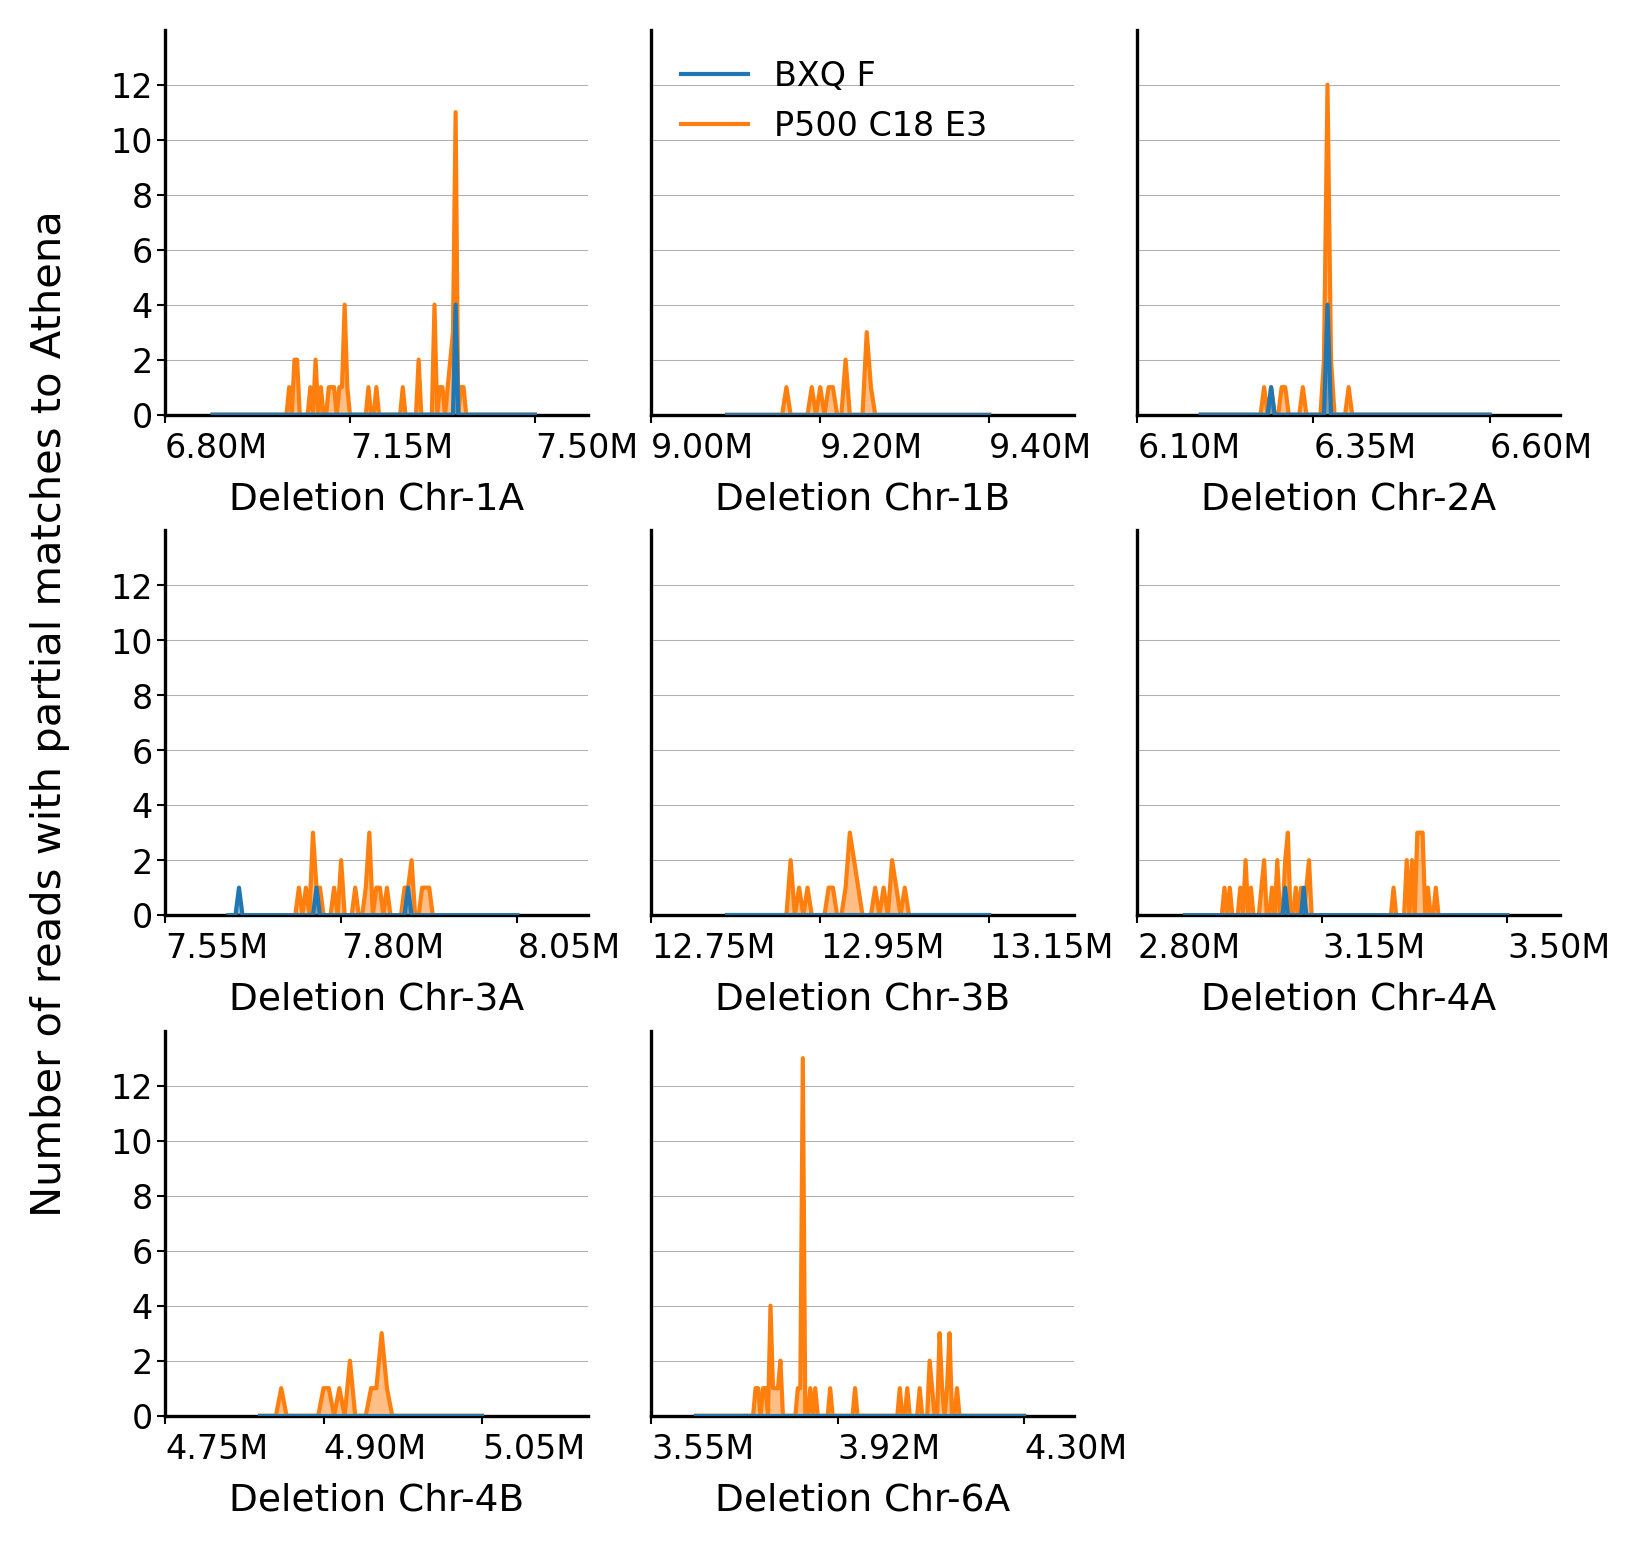

In [32]:
ccycle = list(plt.rcParams['axes.prop_cycle'].by_key()['color'])

fig, axs = plt.subplots(nrows=3, ncols=3, dpi=300, figsize=(6,6))

prev_chr = None
del_count = 1
for i, coords in enumerate(deletion_coordinates):
    
    ax = axs.flatten()[i]
    
    chr, start, end = coords[0], coords[1], coords[2]
    HIT_reads_BXQ = ADF_hits.query('chrom == @chr & start >= @start & end <= @end')
    HIT_reads_PAF = IDF_hits.query('chrom == @chr & start >= @start & end <= @end')
    HIT_ref = hits_df.query('chrom == @chr & start >= @start & end <= @end')

    bins = np.arange(start-10000, end+10000, 5000)
    
    f, b = np.histogram(HIT_reads_BXQ['start'], bins=bins)
    ax.plot(b[:-1], f, label='BXQ F', lw=1.0, color=ccycle[0], zorder=4)
    ax.fill_between(b[:-1], f, 0, lw=0.0, fc=ccycle[0]+"80", zorder=4)
    
    f, b = np.histogram(HIT_reads_PAF['start'], bins=bins)
    ax.plot(b[:-1], f, label='P500 C18 E3', lw=1.0, color=ccycle[1], zorder=2)
    ax.fill_between(b[:-1], f, lw=0.0, fc=ccycle[1]+"80", zorder=2)
    
    #ax.hist(HIT_ref['start'], bins=bins, histtype='stepfilled', label='Reference', lw=1.0, alpha=0.5)

    xticks = np.linspace(start-100000, end, 3)
    ax.set_xticks(xticks)
    ax.set_xticklabels([f"{xi/1e6:.2f}M" for xi in xticks], ha='left')
    ax.set_ylim(0, 14)
    #ax.set_yticks(np.arange(0, 15, 2))
    ax.set_xlim(start-100000, end+100000)

    if chr != prev_chr:
        prev_chr = chr
        del_count = 1
    else:
        del_count += 1

    letter_dc = {1:'A', 2:"B"}
    ax.set_xlabel(f"Deletion Chr-{chr[-1]}{letter_dc[del_count]}", fontsize=9)

    if i == 1:
        ax.legend(fontsize=8, frameon=False, loc='upper left')
    
axs.flatten()[-1].set_visible(False)

for ax in axs.flatten():
    yticks = np.arange(0, 14, 2)
    ax.set_yticks(yticks)
    ax.tick_params(axis='y', labelsize=8, width=0.5, length=2, pad=1)
    ax.tick_params(axis='x', labelsize=8, width=0.5, length=2, pad=2)
    ax.grid(axis="y", zorder=1, lw=0.25)
    ax.spines[['top', 'right']].set_visible(False)
    
for ax in axs[:,1:].flatten():
    ax.set_yticklabels(['' for _ in yticks])
    ax.tick_params(axis="y", length=0, width=0)
    

fig.supylabel('Number of reads with partial matches to Athena', fontsize=10, x=0.05)
fig.subplots_adjust(wspace=0.15, hspace=0.3)

plt.show()

In [228]:
ADF.head()

,name,chrom,start,end,mapq,has_clip,clipped_length,has_match,neo_hits,best_hit_start_on_read,best_hit_length,best_hit_idy,region
0,ch36_read16433_template_pass_,Chrom_1,6970527,7056368,57,True,40,False,51,NaN,NaN,NaN,Chrom_1:7047000-7383000
1,ch60_read5592_template_pass_FAH42885,Chrom_1,6975987,7063056,57,True,59,False,53,NaN,NaN,NaN,Chrom_1:7047000-7383000
2,ch374_read137074_template_pass_FAH42550,Chrom_1,6985894,7061910,57,True,53,False,43,NaN,NaN,NaN,Chrom_1:7047000-7383000
3,ch361_read29603_template_pass_,Chrom_1,7000627,7047581,57,True,19926,False,46,NaN,NaN,NaN,Chrom_1:7047000-7383000
4,ch458_read2409_template_pass_FAH42550,Chrom_1,7002919,7073072,58,True,67054,False,84,NaN,NaN,NaN,Chrom_1:7047000-7383000


('Chrom_1', 6900000, 7500000, 7047000, 7383000) 1532 4521
MWU u(3715142.000); p=2.008e-05
Effect size (rank-biserial): -0.073
x: 0.33 (IQR 0.22-0.49)
y: 0.29 (IQR 0.20-0.45)
('Chrom_1', 9100000, 9400000, 9200000, 9275000) 249 588
MWU u(78258.500); p=1.141e-01
Effect size (rank-biserial): -0.069
x: 0.34 (IQR 0.22-0.52)
y: 0.30 (IQR 0.22-0.44)
('Chrom_2', 6200000, 6600000, 6320000, 6430000) 904 3447
MWU u(1868541.000); p=2.552e-20
Effect size (rank-biserial): -0.199
x: 0.33 (IQR 0.24-0.48)
y: 0.27 (IQR 0.21-0.37)
('Chrom_3', 7650000, 8050000, 7760000, 7930000) 1209 3648
MWU u(2409291.000); p=1.368e-06
Effect size (rank-biserial): -0.093
x: 0.28 (IQR 0.20-0.43)
y: 0.25 (IQR 0.18-0.40)
('Chrom_3', 12850000, 13150000, 12910000, 13060000) 1426 6639
MWU u(5907763.000); p=4.874e-49
Effect size (rank-biserial): -0.248
x: 0.27 (IQR 0.21-0.40)
y: 0.22 (IQR 0.18-0.31)
('Chrom_4', 2900000, 3500000, 3000000, 3370000) 3572 14989
MWU u(24719622.000); p=1.033e-12
Effect size (rank-biserial): 0.077
x: 0

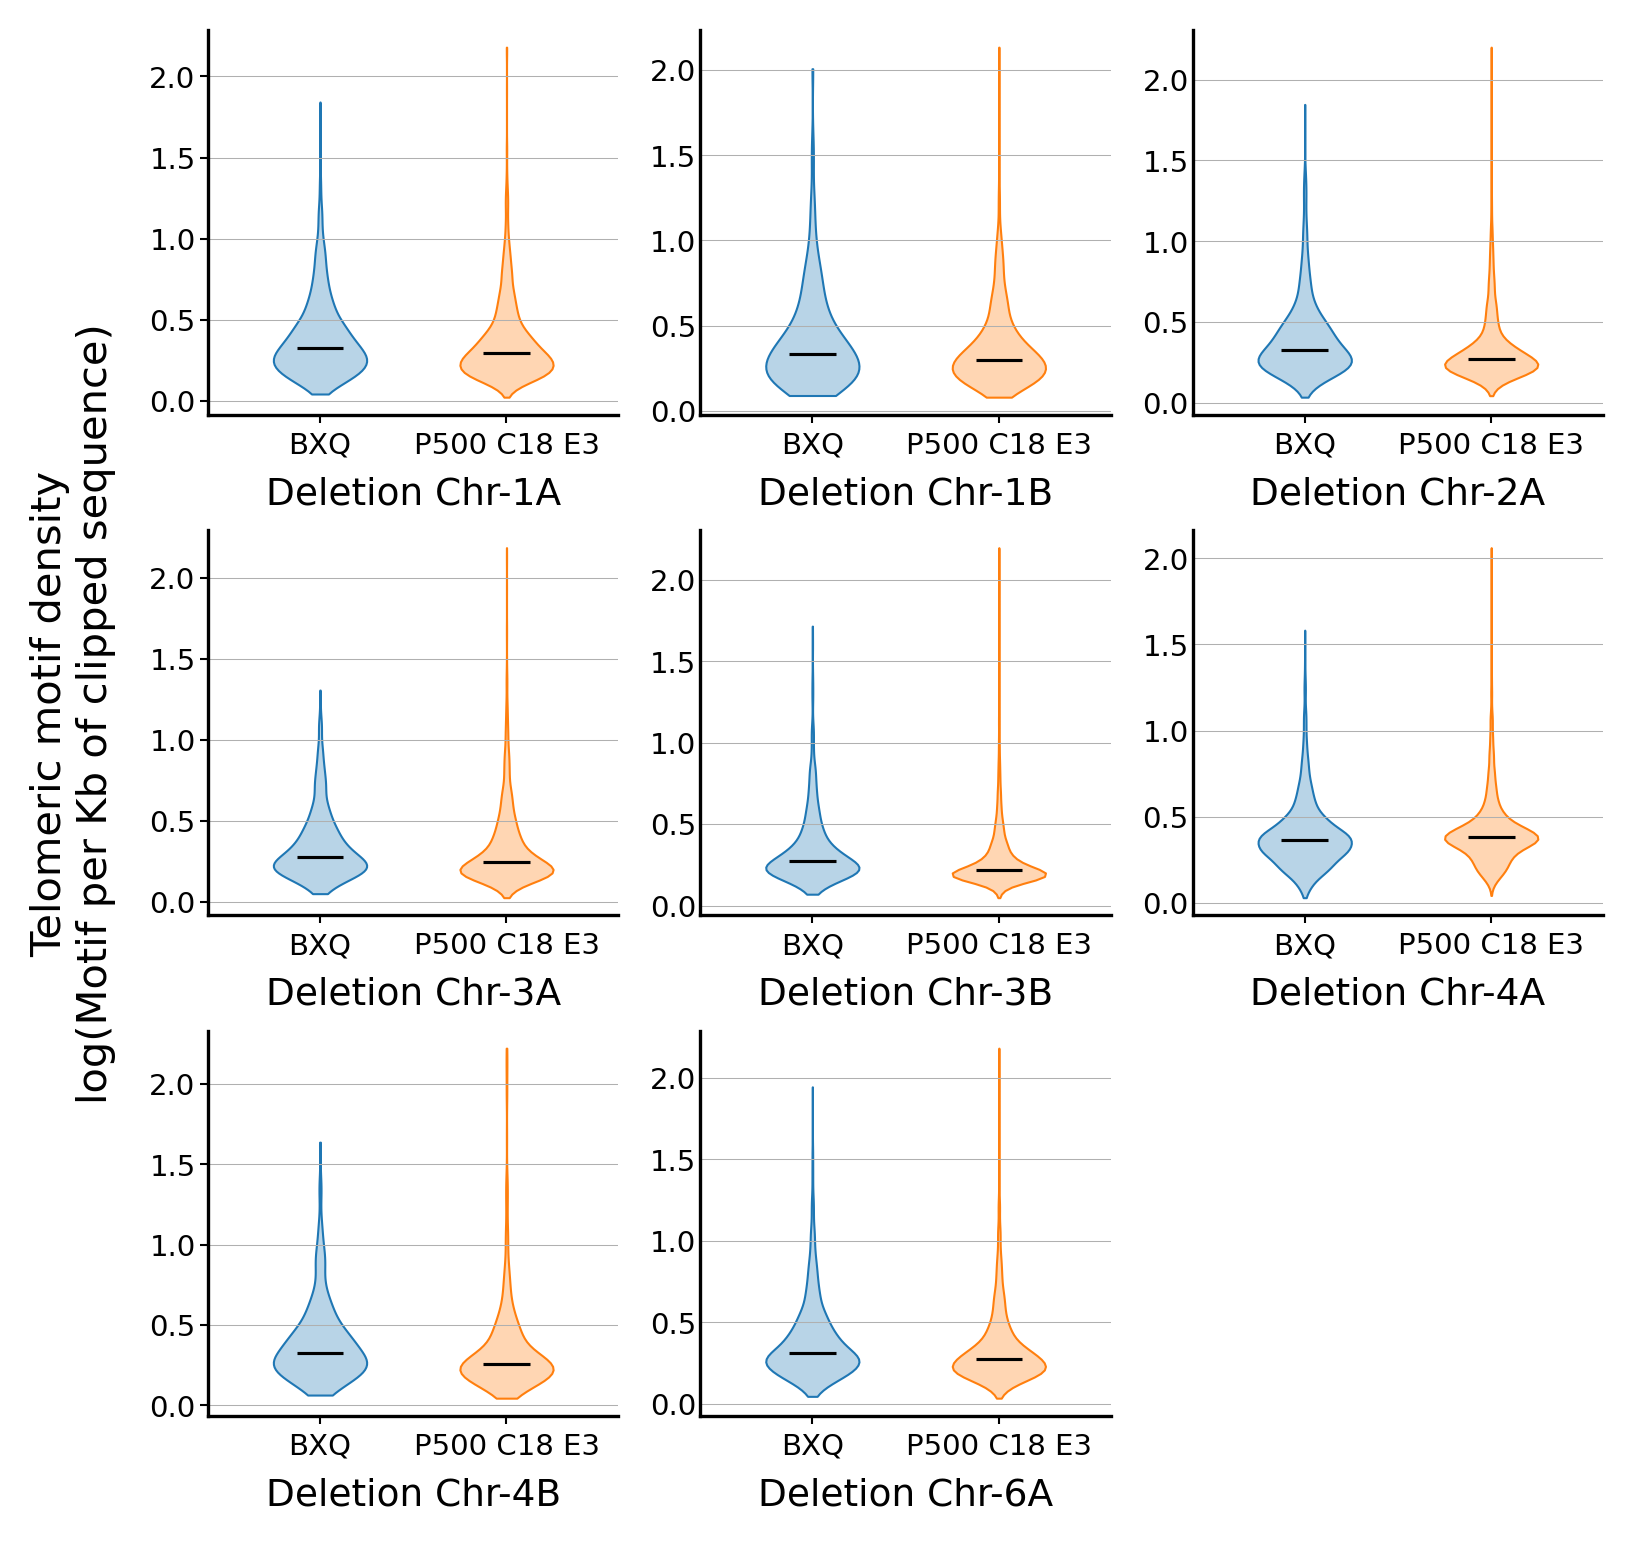

In [25]:
# Mann–Whitney U test (non-parametric, safe for long tails)
from scipy.stats import mannwhitneyu
def rank_biserial(U, n1, n2):
    return 1 - (2 * U) / (n1 * n2)
    
def summarize_and_stats(x, y):
    U, p = mannwhitneyu(x, y, alternative='two-sided')
    print(f"MWU u({U:.3f}); p={p:.3e}")
    effect_size = rank_biserial(U, len(x), len(y))
    print(f"Effect size (rank-biserial): {effect_size:.3f}")
    
    for n, values in zip(['x', 'y'], [x, y]):
        q25, q50, q75 = np.percentile(values, [25, 50, 75])
        print(f"{n}: {q50:.2f} (IQR {q25:.2f}-{q75:.2f})")

ccycle = list(plt.rcParams['axes.prop_cycle'].by_key()['color'])

def format_vps(vps, colors):
    [v.set_alpha(None) for v in vps['bodies']]
    [v.set_color(colors[i]) for i, v in enumerate(vps['bodies'])]
    [v.set_facecolor(colors[i]+'50') for i, v in enumerate(vps['bodies'])]
    [v.set_lw(0.5) for i, v in enumerate(vps['bodies'])]

    vps['cmedians'].set_lw(0.75)
    vps['cmedians'].set_color('k')

    for el in ['cmins', 'cbars', 'cmaxes']:
        vps[el].set_visible(False)

fig, axs = plt.subplots(nrows=3, ncols=3, dpi=300, figsize=(6,6))

prev_chr = None
del_count = 1
for i, coords in enumerate(deletion_coordinates):
    
    ax = axs.flatten()[i]
    
    chr, start, end = coords[0], coords[1], coords[2]
    reads_BXQ = ADF.query('chrom == @chr & start >= @start & end <= @end & neo_hits > 0 & clipped_length > 1000')
    reads_PAF = IDF.query('chrom == @chr & start >= @start & end <= @end & neo_hits > 0 & clipped_length > 1000')
    #HIT_ref = hits_df.query('chrom == @chr & start >= @start & end <= @end')

    total_hits_BXQ = len(reads_BXQ)
    total_hits_PAF = len(reads_PAF)

    # Add per-region normalization
    BXQ_coverage = ADF.query('chrom == @chr & start >= @start & end <= @end')
    PAF_coverage = IDF.query('chrom == @chr & start >= @start & end <= @end')
    
    BXQ_reads = len(BXQ_coverage)
    PAF_reads = len(PAF_coverage)
    
    # Compute normalized motif abundance per read per clipped base
    BXQ_neo_per_read = reads_BXQ['neo_hits'].sum() / BXQ_reads
    PAF_neo_per_read = reads_PAF['neo_hits'].sum() / PAF_reads

    BXQ_motif_density = reads_BXQ['neo_hits'] / (reads_BXQ['clipped_length'] / 1000)
    PAF_motif_density = reads_PAF['neo_hits'] / (reads_PAF['clipped_length'] / 1000)

    #BXQ_neo_clip_ratio = reads_BXQ['neo_hits']/reads_BXQ['clipped_length']
    #PAF_neo_clip_ratio = reads_PAF['neo_hits']/reads_PAF['clipped_length']

    """
    bins = np.linspace(0.0, 1000, 50)
    
    f, b = np.histogram(BXQ_motif_density, bins=bins)
    ax.plot(b[:-1], f, label='BXQ F', lw=1.0, color=ccycle[0], zorder=4)
    ax.fill_between(b[:-1], f, 0, lw=0.0, fc=ccycle[0]+"80", zorder=4)
    
    f, b = np.histogram(PAF_motif_density, bins=bins)
    ax.plot(b[:-1], f, label='P500 C18 E3', lw=1.0, color=ccycle[1], zorder=2)
    ax.fill_between(b[:-1], f, lw=0.0, fc=ccycle[1]+"80", zorder=2)
    
    #ax.hist(HIT_ref['start'], bins=bins, histtype='stepfilled', label='Reference', lw=1.0, alpha=0.5)
    """

    BXQ_log_density = np.log10(BXQ_motif_density + 1)
    PAF_log_density = np.log10(PAF_motif_density + 1)

    

    print(coords, len(BXQ_motif_density), len(PAF_motif_density))
    summarize_and_stats(BXQ_log_density, PAF_log_density)
    
    data = [BXQ_log_density, PAF_log_density]
    vps = ax.violinplot(data, positions=[0,1], showmedians=True)
    format_vps(vps, colors=[ccycle[0], ccycle[1]])

    ax.set_xticks([0, 1])
    ax.set_xticklabels(['BXQ', 'P500 C18 E3'])

    if chr != prev_chr:
        prev_chr = chr
        del_count = 1
    else:
        del_count += 1

    letter_count_dc = {1:"A", 2:"B"}
    ax.set_xlabel(f"Deletion Chr-{chr[-1]}{letter_count_dc[del_count]}", fontsize=9)

    """
    if i == 0:
        ax.legend(fontsize=6, frameon=False, loc='upper right')
    """
axs.flatten()[-1].set_visible(False)

for ax in axs.flatten():
    #yticks = np.arange(0, 14, 2)
    #ax.set_yticks(yticks)
    #ax.set_yscale('log')
    #ax.set_ylim(1, 50)
    ax.tick_params(axis='y', labelsize=7, width=0.5, length=2, pad=1)
    ax.tick_params(axis='x', labelsize=7, width=0.5, length=2, pad=2)
    ax.grid(axis="y", zorder=1, lw=0.25)
    ax.spines[['top', 'right']].set_visible(False)
    ax.set_xlim(-0.6,1.6)
    
for ax in axs[:,1:].flatten():
    #ax.set_yticklabels(['' for _ in yticks])
    ax.tick_params(axis="y", length=0, width=0)
    
    

fig.supylabel('Telomeric motif density\nlog(Motif per Kb of clipped sequence)', fontsize=10, x=0.05, ha='center')
fig.subplots_adjust(wspace=0.2, hspace=0.3)

plt.show()

### Scan positions of read-interruptions

In [17]:
import numpy as np
import pysam

ccycle = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [4]:
C_SOFT = 4
C_HARD = 5

def get_end_clips(read: pysam.AlignedSegment):
    """
    Returns (left_clip, right_clip) in query/read orientation.
    Includes soft + hard clips if present at the ends.
    """
    ct = read.cigartuples
    if not ct:
        return 0, 0

    left = 0
    right = 0

    op0, n0 = ct[0]
    if op0 in (C_SOFT, C_HARD):
        left += n0
        # Handle edge case: H then S (or S then H) at same end
        if len(ct) > 1:
            op1, n1 = ct[1]
            if op1 in (C_SOFT, C_HARD):
                left += n1

    opL, nL = ct[-1]
    if opL in (C_SOFT, C_HARD):
        right += nL
        if len(ct) > 1:
            opLm1, nLm1 = ct[-2]
            if opLm1 in (C_SOFT, C_HARD):
                right += nLm1

    return left, right

In [5]:
def count_stops(
    bam_path: str,
    chrom: str,
    start0: int,   # 0-based inclusive
    end0: int,     # 0-based exclusive
    mapq_min: int = 10,
    include_secondary: bool = False,
    include_supplementary: bool = False,
):
    """
    Returns dict of numpy arrays with counts at each reference position in [start0, end0]
    plus a margin for unclipped extensions (handled by dynamic dict counting).
    """
    # We’ll store counts in dicts to avoid worrying about array bounds for unclipped ends.
    left_stop = {}
    right_stop = {}
    left_unclipped = {}
    right_unclipped = {}

    def inc(d, pos):
        d[pos] = d.get(pos, 0) + 1

    with pysam.AlignmentFile(bam_path, "rb") as bam:
        for r in bam.fetch(chrom, start0, end0):
            if r.is_unmapped:
                continue
            if (not include_secondary) and r.is_secondary:
                continue
            if (not include_supplementary) and r.is_supplementary:
                continue
            if r.mapping_quality < mapq_min:
                continue

            # observed ends on reference
            rs = r.reference_start          # 0-based inclusive
            re = r.reference_end            # 0-based exclusive
            if rs is None or re is None:
                continue

            # count observed "stops"
            inc(left_stop, rs)
            inc(right_stop, re)

            # unclipped heuristic
            left_clip, right_clip = get_end_clips(r)

            if not r.is_reverse:
                # forward: right end is at reference_end
                inc(right_unclipped, re + right_clip)
                inc(left_unclipped, rs - left_clip)
            else:
                # reverse: query's right end corresponds to reference_start side
                # so "stop" at that side would shift upstream by right_clip
                inc(left_unclipped, rs - right_clip)
                inc(right_unclipped, re + left_clip)

    return {
        "left_stop": left_stop,
        "right_stop": right_stop,
        "left_unclipped": left_unclipped,
        "right_unclipped": right_unclipped,
    }


In [24]:
def dict_to_track(d, start0, end0):
    """
    Builds an int array of length (end0-start0+1) indexing positions [start0..end0] inclusive
    from a dict {pos0: count}. Positions outside are ignored.
    """
    n = end0 - start0 + 1
    arr = np.zeros(n, dtype=np.int32)
    for pos, c in d.items():
        if start0 <= pos <= end0:
            arr[pos - start0] += c
    return arr

#### Analyzing deletions

In [25]:
# BAMS
bam_anc = "../2023-10-04_Telomeric_Motifs_In_ONT/BXQF_v_AV20.ngmlr.sorted.bam"
bam_irr = "../2023-10-04_Telomeric_Motifs_In_ONT/PAF_PAG.ngmlr.AV20.sorted.bam"
bam_anc_ILLU = "../19-11-21_VariantCalling_ARC/ancestor/ancestor.sorted.CALL.bam"

# COORDS
deletion_coordinates = [
    #chrom, start, end, delstart, delend
    ("Chrom_1", 6900000, 7500000, 7047000, 7383000),
    ("Chrom_1", 9100000, 9400000, 9200000, 9275000),
    ("Chrom_2", 6200000, 6600000, 6320000, 6430000),
    ("Chrom_3", 7650000, 8050000, 7760000, 7930000),
    ("Chrom_3", 12850000, 13150000, 12910000, 13060000),
    ("Chrom_4", 2900000, 3500000, 3000000, 3370000),
    ("Chrom_4", 4850000, 5050000, 4900000, 4990000),
    ("Chrom_6", 3650000, 4300000, 3780000, 4170000),
]

In [43]:
fcov_ont = "/mnt/urbe2/disk3/Antoine/21-12-21_VariantCalling_ARC_500Gy_ONT/PAF_PAG.ngmlr.AV20.sorted.cov.gz"
cov = pd.read_csv(fcov_ont, sep='\t', header=0, usecols=range(3))
cov

,REF,POS,COV
0,Chrom_3,0,21
1,Chrom_3,1,23
2,Chrom_3,2,24
3,Chrom_3,3,25
4,Chrom_3,4,26
...,...,...,...
100824823,Chrom_6,13893205,0
100824824,Chrom_6,13893206,0
100824825,Chrom_6,13893207,0
100824826,Chrom_6,13893208,0


### First deletion

In [104]:
deletion_number = 0
chrom, start, end = deletion_coordinates[deletion_number][0], deletion_coordinates[deletion_number][1], deletion_coordinates[deletion_number][2]
delstart, delend = deletion_coordinates[deletion_number][3], deletion_coordinates[deletion_number][4]
counts = count_stops(bam_irr, chrom, start, end)

right_stop_track = dict_to_track(counts["right_stop"], start, end)
right_unclipped_track = dict_to_track(counts["right_unclipped"], start, end)

data = pd.DataFrame(
    {
        "POS":np.arange(start, end+1),
        "nstop":right_unclipped_track,
        "REF":[chrom for _ in range(start, end+1)]
    }
)
data = pd.merge(cov, data, on=["REF", "POS"])
bins = np.arange(start, end+500, 500)
data = data.assign(BIN=pd.cut(data['POS'], bins, include_lowest=True))
#data["stop_density"] = data['nstop']/data["COV"]
data

,REF,POS,COV,nstop,BIN
0,Chrom_1,6900000,942,0,"(6899999.999, 6900500.0]"
1,Chrom_1,6900001,943,0,"(6899999.999, 6900500.0]"
2,Chrom_1,6900002,943,0,"(6899999.999, 6900500.0]"
3,Chrom_1,6900003,943,0,"(6899999.999, 6900500.0]"
4,Chrom_1,6900004,943,0,"(6899999.999, 6900500.0]"
...,...,...,...,...,...
599996,Chrom_1,7499996,1007,0,"(7499500.0, 7500000.0]"
599997,Chrom_1,7499997,1007,0,"(7499500.0, 7500000.0]"
599998,Chrom_1,7499998,1007,0,"(7499500.0, 7500000.0]"
599999,Chrom_1,7499999,1007,0,"(7499500.0, 7500000.0]"


In [105]:
windows = data.groupby(by="BIN", observed=True).agg({
    "REF": "first",
    "POS": "min",
    "COV": ["min", "max", "mean", "std"],
    "nstop": ["min", "max", "mean", "std"],
})
windows

REF      POS   COV                               \
                            first      min   min   max         mean       std   
BIN                                                                             
(6899999.999, 6900500.0]  Chrom_1  6900000   935   946   940.956088  3.293337   
(6900500.0, 6901000.0]    Chrom_1  6900501   934   944   941.308000  2.440707   
(6901000.0, 6901500.0]    Chrom_1  6901001   943   960   949.778000  5.338325   
(6901500.0, 6902000.0]    Chrom_1  6901501   954   966   959.212000  2.909293   
(6902000.0, 6902500.0]    Chrom_1  6902001   955   963   958.506000  1.769810   
...                           ...      ...   ...   ...          ...       ...   
(7497500.0, 7498000.0]    Chrom_1  7497501   994  1006  1000.806000  3.196373   
(7498000.0, 7498500.0]    Chrom_1  7498001  1001  1009  1005.296000  2.103624   
(7498500.0, 7499000.0]    Chrom_1  7498501  1003  1009  1005.938000  1.460967   
(7499000.0, 7499500.0]    Chrom_1  7499001  1000  1016  1008.104000  4.239946   
(7499500.0, 7500000.0]    Chrom_1  7499501  1005  1016  1010.752000  2.943437   

                         nstop                          
                           min max      mean       std  
BIN                                                     
(6899999.999, 6900500.0]     0   2  0.053892  0.243084  
(6900500.0, 6901000.0]       0   1  0.056000  0.230152  
(6901000.0, 6901500.0]       0   2  0.036000  0.196930  
(6901500.0, 6902000.0]       0   1  0.066000  0.248531  
(6902000.0, 6902500.0]       0   2  0.042000  0.210534  
...                        ...  ..       ...       ...  
(7497500.0, 7498000.0]       0   2  0.066000  0.256467  
(7498000.0, 7498500.0]       0   1  0.048000  0.213980  
(7498500.0, 7499000.0]       0   1  0.054000  0.226244  
(7499000.0, 7499500.0]       0   2  0.044000  0.223974  
(7499500.0, 7500000.0]       0   1  0.064000  0.244998  

[1200 rows x 10 columns]

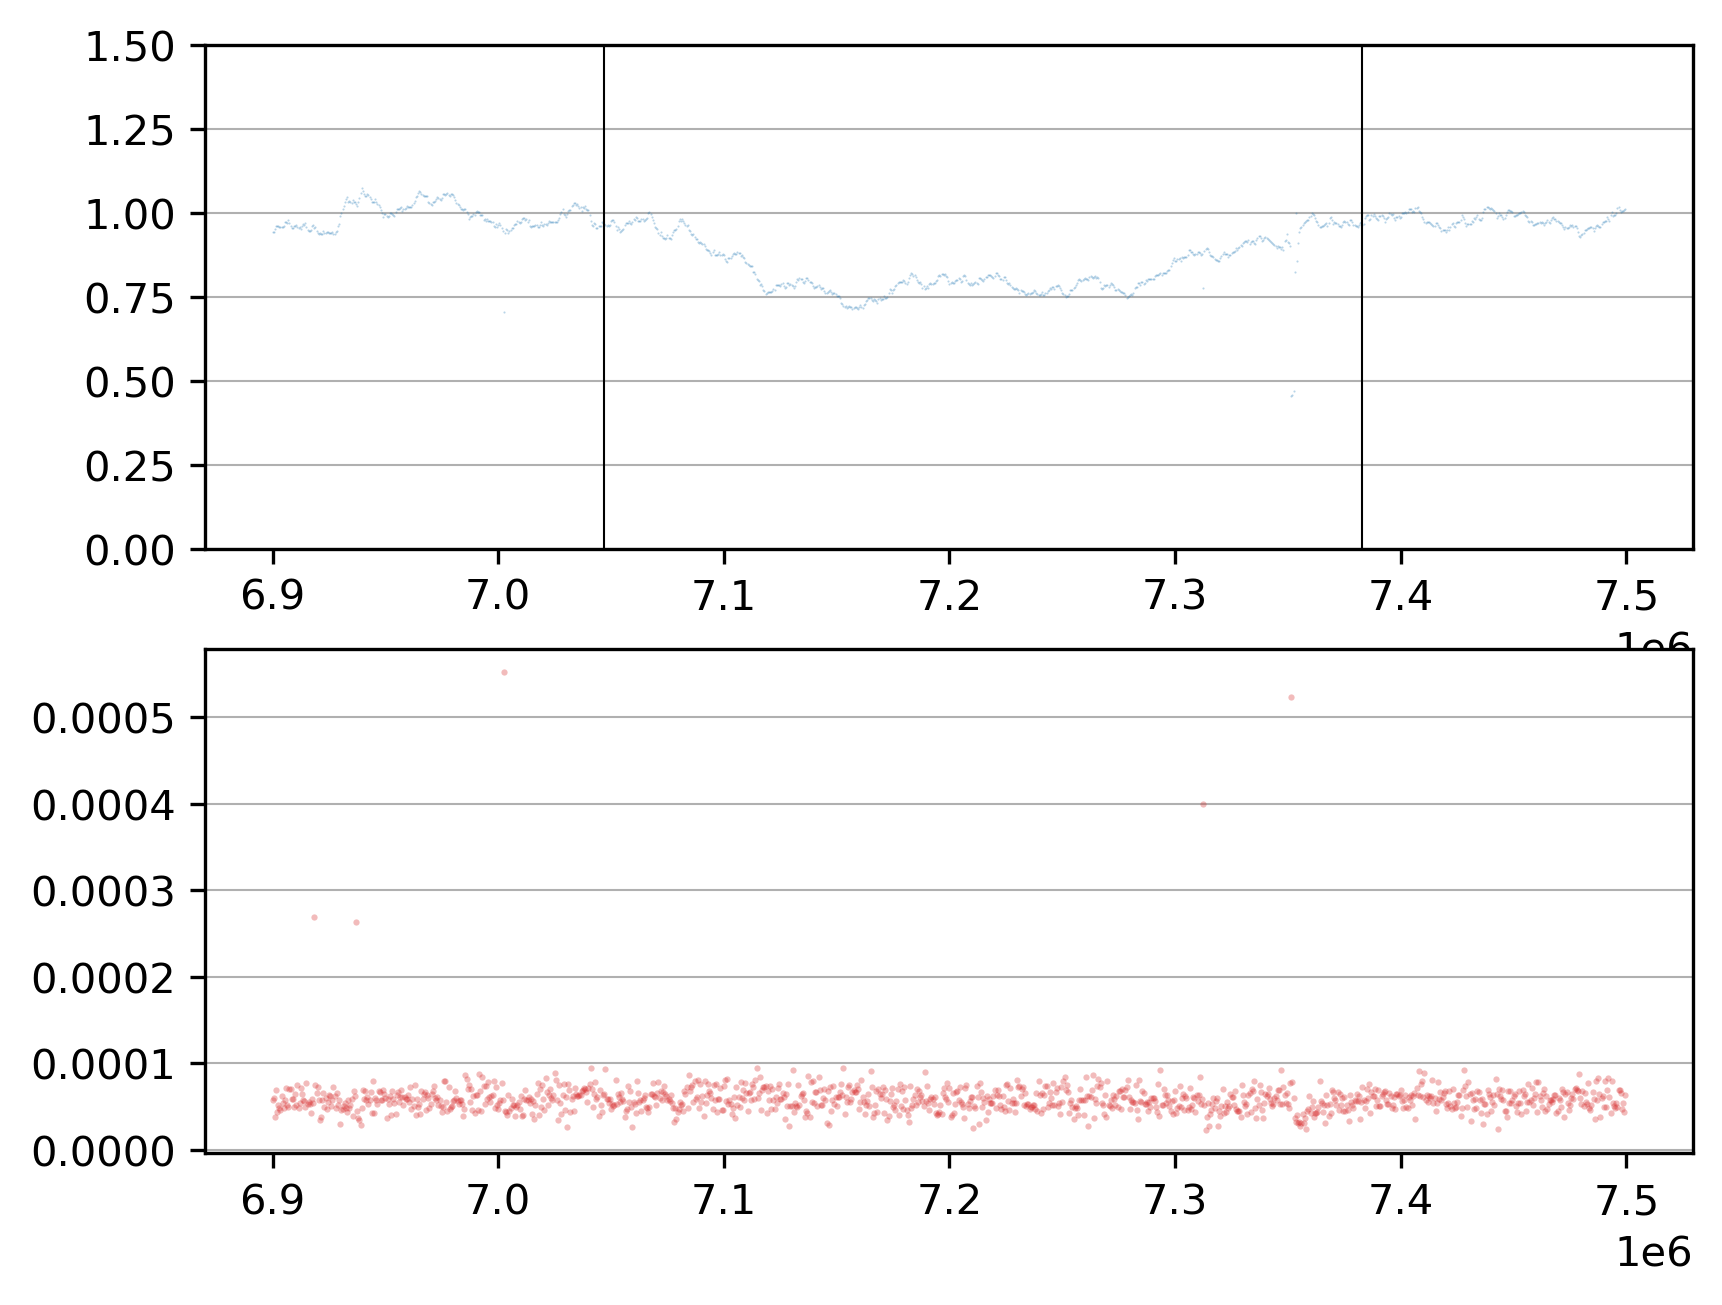

In [111]:
fig, axs = plt.subplots(dpi=300, nrows=2)

ax = axs[0]
ax.plot(windows[("POS", "min")], windows[("COV", "mean")].div(1000), lw=0, ms=1, marker='.', mew=0, mfc=ccycle[0]+"50")
ax.vlines(x=[delstart, delend], ymin=0, ymax=1.5, lw=0.5, color='k')
ax.set_ylim(0, 1.5)

ax = axs[1]
#ax.fill_between(windows[("POS", "min")], 0, windows[("nstop", "mean")]+windows[("nstop", "std")],
#                lw=0, fc=ccycle[3]+"50")
#ax.set_yscale('log')
ax.plot(windows[("POS", "min")], windows[("nstop", "mean")]/windows[("COV", "mean")], lw=0, ms=3, marker='.', mew=0, mfc=ccycle[3]+"50")
#ax.vlines(x=[delstart, delend], ymin=-1, ymax=1, lw=0.5, color='k')
#ax.set_ylim(0,1)

for ax in axs:
    ax.grid(axis='y', lw=0.5, zorder=1)

plt.show()

In [83]:
deletion_number = 7
chrom, start, end = deletion_coordinates[deletion_number][0], deletion_coordinates[deletion_number][1], deletion_coordinates[deletion_number][2]
delstart, delend = deletion_coordinates[deletion_number][3], deletion_coordinates[deletion_number][4]
counts = count_stops(bam_irr, chrom, start, end)

right_stop_track = dict_to_track(counts["right_stop"], start, end)
right_unclipped_track = dict_to_track(counts["right_unclipped"], start, end)

data = pd.DataFrame(
    {
        "POS":np.arange(start, end+1),
        "nstop":right_stop_track,
        "REF":[chrom for _ in range(start, end+1)]
    }
)
data = pd.merge(cov, data, on=["REF", "POS"])
data["stop_density"] = data['nstop']/data["COV"]
data

,REF,POS,COV,nstop,stop_density
0,Chrom_6,3650000,1005,0,0.0
1,Chrom_6,3650001,1005,0,0.0
2,Chrom_6,3650002,1006,0,0.0
3,Chrom_6,3650003,1006,0,0.0
4,Chrom_6,3650004,1006,0,0.0
...,...,...,...,...,...
649996,Chrom_6,4299996,1066,0,0.0
649997,Chrom_6,4299997,1066,0,0.0
649998,Chrom_6,4299998,1066,0,0.0
649999,Chrom_6,4299999,1066,0,0.0


In [92]:
rol_std = data['stop_density'].rolling(window=500).std()

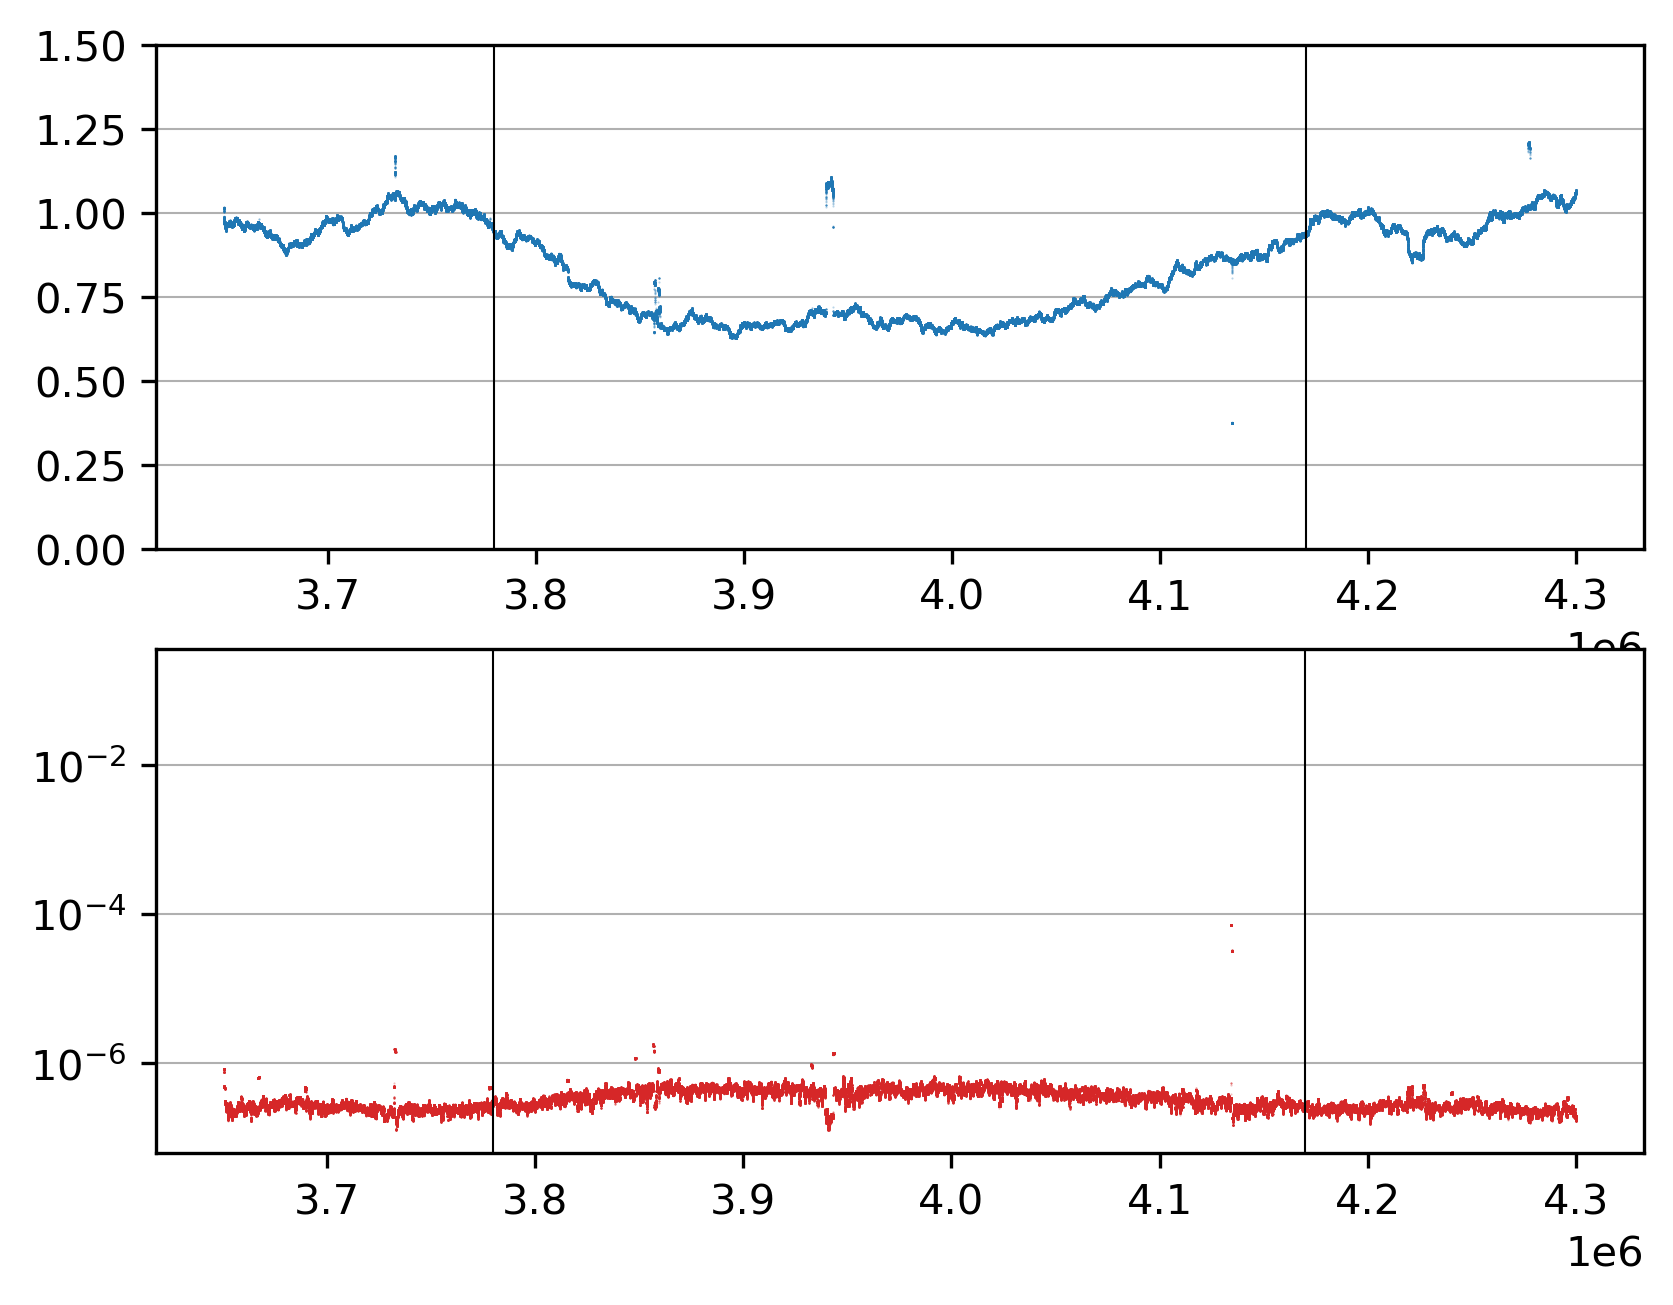

In [93]:
fig, axs = plt.subplots(dpi=300, nrows=2)

ax = axs[0]
ax.plot(data["POS"], data["COV"].div(1000), lw=0, ms=1, marker='.', mew=0, mfc=ccycle[0]+"50")
ax.vlines(x=[delstart, delend], ymin=0, ymax=1.5, lw=0.5, color='k')
ax.set_ylim(0, 1.5)

ax = axs[1]
ax.plot(data["POS"], rol_std/data["COV"], lw=0, ms=1, marker='.', mew=0, mfc=ccycle[3]+"50")
ax.set_yscale('log')
ax.vlines(x=[delstart, delend], ymin=0, ymax=1.5, lw=0.5, color='k')
#ax.set_ylim(5e-5,1e-1)

for ax in axs:
    ax.grid(axis='y', lw=0.5, zorder=1)

plt.show()

#### Tests

In [152]:
telomeric_motif = "TGTGGG"
all_telo = get_all_motif_kmers(telomeric_motif)
# Join substrings into a regex pattern
pattern = "|".join(re.escape(sub) for sub in all_telo)

print(pattern)

CACACC|TGTGGG|CACCCA|TGGGTG|CCACAC|GGTGTG|CCCACA|GTGTGG|ACCCAC|GTGGGT|GGGTGT|ACACCC


In [170]:
sequence_test = 'CATGTGGGCACACCACACCCACACCACCCCTGTGGGCACCCATGGGTGCCACACGGTGTGCCCACAGTGTGGACCCACGTGGGTGGGTGTACACCCGGGTGTTGGTGTGGGTGTGGTGTGGGTGTGGGTGTGGTGTGGGGTGTGGG'
neotelomere_matches = re.findall(pattern, sequence_test)
len(neotelomere_matches)

22

In [169]:
for m in neotelomere_matches:
    print(m)

TGTGGG
CACACC
ACACCC
TGTGGG
CACCCA
TGGGTG
CCACAC
GGTGTG
CCCACA
GTGTGG
ACCCAC
GTGGGT
GGGTGT
ACACCC
GGGTGT
GGTGTG
GGTGTG
GTGTGG
GTGTGG
GTGTGG
TGTGGG
GTGTGG
